In [1]:
import pennylane as qml
from pennylane import numpy as np
import scipy
import matplotlib.pyplot as plt
from globalVars import *
from model_6qubit import *

from GRADest_6Q import EstGrad
from EQFIMest_6Q import Est_EQFIM

## Quantum Neural Network

(<Figure size 1500x700 with 1 Axes>, <Axes: >)

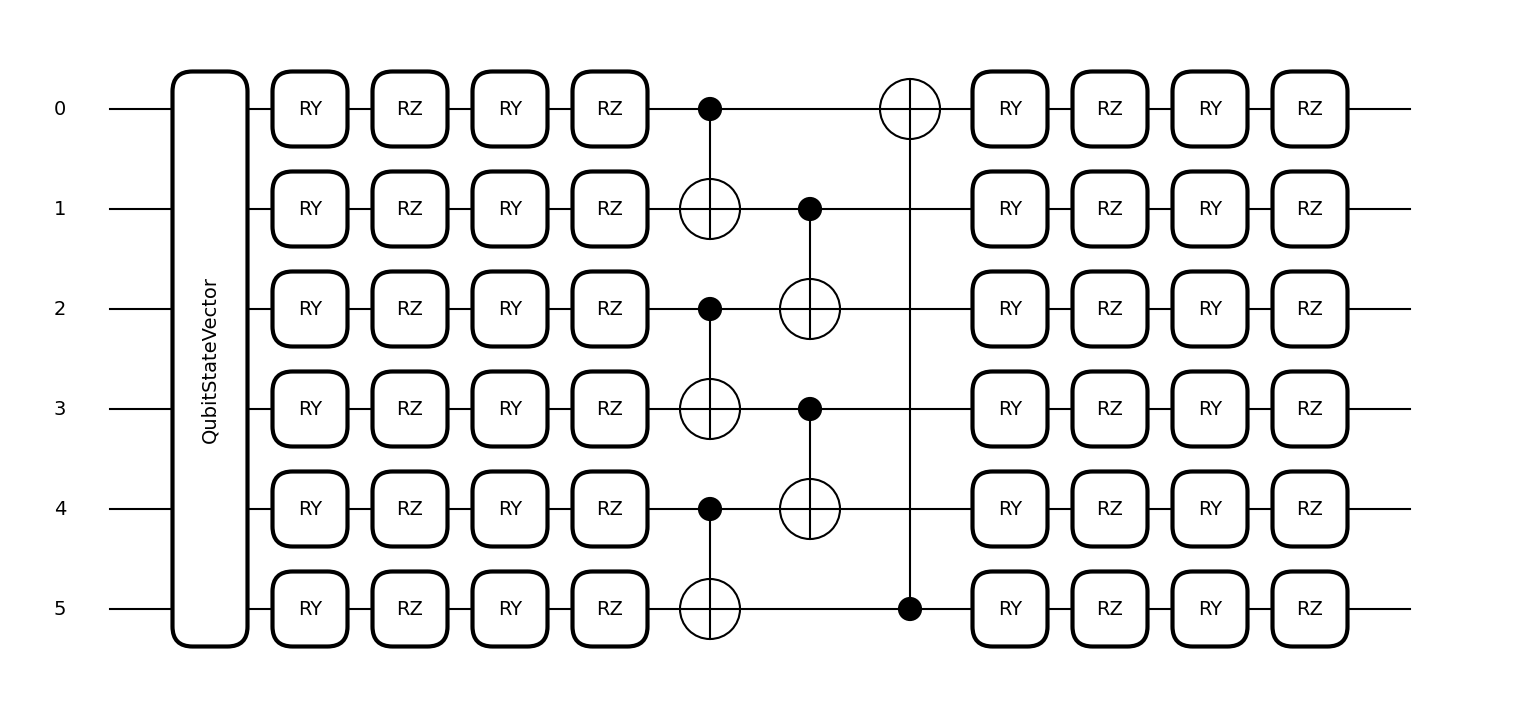

In [2]:
random_state = np.random.rand(dim)
random_state = random_state /np.linalg.norm(random_state)
qml.draw_mpl(QNN)(np.zeros(nparams),random_state)

### Model Initialization 

In [3]:
S_pItr = 6  # no. of samples used per-iteration 

nStep = 500
nItr = 100
step_size = 0.0025

Bsize = S_pItr*nItr

In [4]:
phiTrain = np.load('6-qubitsPhiTrain_v1.npy')
labelTrain = np.load('6-qubitsLabelTrain_v1.npy')

phiTrain.requires_grad = False
labelTrain.requires_grad = False

In [5]:
'QNSCD Dataset'
phiTrainNCGD = phiTrain
labelTrainNCGD = labelTrain

'SGD Dataset'
phiTrainSGD = phiTrain
labelTrainSGD = labelTrain

In [6]:
### Optimal Expected Loss
Opt_cost = []
itrBatch = np.linspace(0,Bsize*nStep,nStep,endpoint = False,dtype = 'int').tolist()
for itr1 in itrBatch:
    expOperator = 0
    for itr2 in range(Bsize):
        temp_phi = phiTrain[:,itr1+itr2]
        op = np.matmul(temp_phi.reshape(dim,1),temp_phi.reshape(1,dim))
        expOperator = expOperator + labelTrain[itr1+itr2]*op
    expOperator = expOperator/Bsize
    opt_value = 0.5*(1-sum(abs(np.linalg.svd(expOperator)[1])))
    Opt_cost.append(opt_value)

file_name = "6Q-Minimum Expected Loss"
np.save(file_name,Opt_cost)

# Optimizers

In [7]:
'QNN outputs yhat'
dev = qml.device("default.qubit", wires=nqubits, shots=1)

@qml.qnode(dev,interface='autograd')
def circuit_test(params,state):
    QNN(params,state)
    return qml.sample(qml.Hermitian(M,wires=list(range(nqubits))))

In [8]:
init_params = np.random.uniform(low=0, high=2*np.pi, size=nparams, requires_grad=True)
init_params = np.array([4.18395451, 2.80027694, 0.85397153, 4.48443259, 3.57604965, 1.19944617,
 0.41247005, 4.63045018, 1.35630851, 4.91395967, 1.19422007, 4.23673124,
 5.52007002, 0.87152415, 4.62032059, 5.70775899, 0.98443816, 2.60620952,
 3.10142082, 1.23994968, 3.39490718, 1.96179533, 1.15018634, 0.59254022,
 5.39154729, 5.5937083,  6.14010443, 1.56187484, 3.49360803, 1.47056579,
 6.22803207, 5.56612399, 2.66676056, 2.80825993, 3.10406052, 3.61217839,
 4.069484,  1.18787981, 5.22398449, 3.66048667, 1.33690748, 3.11900939,
 1.08570153, 3.78373175, 0.78827912, 6.27637708, 0.52677955, 2.4871536],requires_grad = True)

'cost initialization'
phiTrain0 = phiTrain[:,-1*(Bsize+1):-1]
labelTrain0 = labelTrain[-1*(Bsize+1):-1]
temp_cost = sum([ps_expLoss(init_params,phiTrain0[:,itr],labelTrain0[itr]) for itr in range(Bsize)])/Bsize
print("Initial Average Per-Sample Expected Loss: ",temp_cost)

count = 0
for itr in range(Bsize):
    if circuit_test(init_params,phiTrain0[:,itr]) != labelTrain0[itr]:
        count += 1
temp_Ecost = count/Bsize
print("Initial Average Empirical Loss", temp_Ecost)

Initial Average Per-Sample Expected Loss:  0.6020316514864771
Initial Average Empirical Loss 0.605


## Quantum Natural Stochastic Pairwise Coordinate Descent (2-QNSCD)

In [9]:
NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr])

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "6Q 2-QNSCD Expected Loss"
file_name2 = "6Q 2-QNSCD Empirical Loss"

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.61345
Batch count:  1, Avg. per-sample expected Loss: 0.59704
Batch count:  2, Avg. per-sample expected Loss: 0.59963
Batch count:  3, Avg. per-sample expected Loss: 0.59637
Batch count:  4, Avg. per-sample expected Loss: 0.61014
Batch count:  5, Avg. per-sample expected Loss: 0.60843
Batch count:  6, Avg. per-sample expected Loss: 0.59501
Batch count:  7, Avg. per-sample expected Loss: 0.61562
Batch count:  8, Avg. per-sample expected Loss: 0.61853
Batch count:  9, Avg. per-sample expected Loss: 0.58975
Batch count: 10, Avg. per-sample expected Loss: 0.61161
Batch count: 11, Avg. per-sample expected Loss: 0.59798
Batch count: 12, Avg. per-sample expected Loss: 0.59921
Batch count: 13, Avg. per-sample expected Loss: 0.59712
Batch count: 14, Avg. per-sample expected Loss: 0.60433
Batch count: 15, Avg. per-sample expected Loss: 0.59856
Batch count: 16, Avg. per-sample expected Loss: 0.60822
Batch count: 17, Avg. per-sample expected Loss: 

Batch count: 146, Avg. per-sample expected Loss: 0.55366
Batch count: 147, Avg. per-sample expected Loss: 0.55027
Batch count: 148, Avg. per-sample expected Loss: 0.54613
Batch count: 149, Avg. per-sample expected Loss: 0.54482
Batch count: 150, Avg. per-sample expected Loss: 0.54744
Batch count: 151, Avg. per-sample expected Loss: 0.55524
Batch count: 152, Avg. per-sample expected Loss: 0.55240
Batch count: 153, Avg. per-sample expected Loss: 0.54642
Batch count: 154, Avg. per-sample expected Loss: 0.55015
Batch count: 155, Avg. per-sample expected Loss: 0.53978
Batch count: 156, Avg. per-sample expected Loss: 0.54842
Batch count: 157, Avg. per-sample expected Loss: 0.54444
Batch count: 158, Avg. per-sample expected Loss: 0.53878
Batch count: 159, Avg. per-sample expected Loss: 0.54389
Batch count: 160, Avg. per-sample expected Loss: 0.53931
Batch count: 161, Avg. per-sample expected Loss: 0.54162
Batch count: 162, Avg. per-sample expected Loss: 0.53940
Batch count: 163, Avg. per-samp

Batch count: 290, Avg. per-sample expected Loss: 0.33112
Batch count: 291, Avg. per-sample expected Loss: 0.32826
Batch count: 292, Avg. per-sample expected Loss: 0.32233
Batch count: 293, Avg. per-sample expected Loss: 0.33302
Batch count: 294, Avg. per-sample expected Loss: 0.33082
Batch count: 295, Avg. per-sample expected Loss: 0.33485
Batch count: 296, Avg. per-sample expected Loss: 0.31906
Batch count: 297, Avg. per-sample expected Loss: 0.32388
Batch count: 298, Avg. per-sample expected Loss: 0.32876
Batch count: 299, Avg. per-sample expected Loss: 0.33432
Batch count: 300, Avg. per-sample expected Loss: 0.34462
Batch count: 301, Avg. per-sample expected Loss: 0.33684
Batch count: 302, Avg. per-sample expected Loss: 0.33262
Batch count: 303, Avg. per-sample expected Loss: 0.32624
Batch count: 304, Avg. per-sample expected Loss: 0.31133
Batch count: 305, Avg. per-sample expected Loss: 0.33187
Batch count: 306, Avg. per-sample expected Loss: 0.32416
Batch count: 307, Avg. per-samp

Batch count: 434, Avg. per-sample expected Loss: 0.19424
Batch count: 435, Avg. per-sample expected Loss: 0.18922
Batch count: 436, Avg. per-sample expected Loss: 0.19296
Batch count: 437, Avg. per-sample expected Loss: 0.18355
Batch count: 438, Avg. per-sample expected Loss: 0.19396
Batch count: 439, Avg. per-sample expected Loss: 0.20120
Batch count: 440, Avg. per-sample expected Loss: 0.18882
Batch count: 441, Avg. per-sample expected Loss: 0.18938
Batch count: 442, Avg. per-sample expected Loss: 0.17641
Batch count: 443, Avg. per-sample expected Loss: 0.18555
Batch count: 444, Avg. per-sample expected Loss: 0.19483
Batch count: 445, Avg. per-sample expected Loss: 0.19406
Batch count: 446, Avg. per-sample expected Loss: 0.19239
Batch count: 447, Avg. per-sample expected Loss: 0.19617
Batch count: 448, Avg. per-sample expected Loss: 0.16968
Batch count: 449, Avg. per-sample expected Loss: 0.18153
Batch count: 450, Avg. per-sample expected Loss: 0.20412
Batch count: 451, Avg. per-samp

## Plots

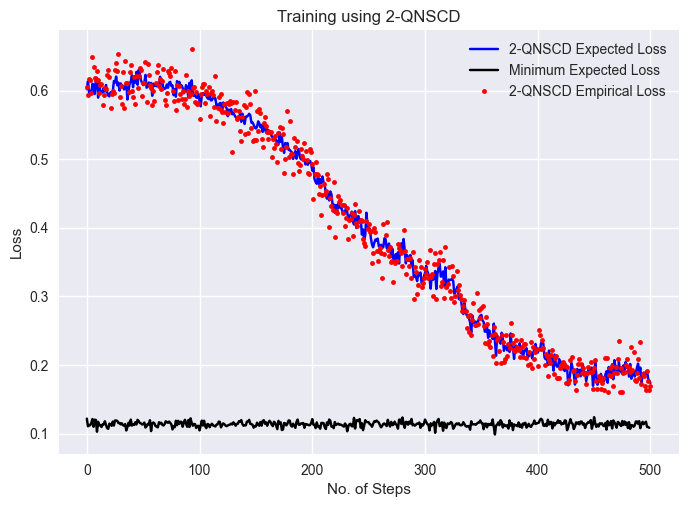

In [10]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "b", label="2-QNSCD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.", label="2-QNSCD Empirical Loss")

plt.title("Training using 2-QNSCD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.show()

## 6-RQSGD using 600 samples per step 

In [12]:
SGD6cparams = np.array(init_params)
SGD6c_cost = []
SGD6c_Ecost = []

SGD6c_cost.append(temp_cost)
SGD6c_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainSGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainSGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a 6 coordinates
        idx = sorted(np.random.permutation(nparams)[0:6].tolist())
        
        grad = []
        
        ### Gradient estimation
        for i_grad in range(6):
            y_hat,b = EstGrad(SGD6cparams,phiT[:,itr3+i_grad],idx[i_grad])
            b = (1-b)/2
            grad.append((-1)*((-1)**b)*loss(y_hat,labelT[itr3+i_grad]))

        ### single-parameter update
        SGD6cparams[idx] = SGD6cparams[idx] - np.dot(step_size,grad)
    
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(SGD6cparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    SGD6c_cost.append(energy)
    
    ### average empirical loss calculation
    SGD6ccount = 0   
    for itr in range(Bsize):
        if circuit_test(SGD6cparams,phiT[:,itr]) != labelT[itr]:
            SGD6ccount += 1
    SGD6c_Ecost.append(SGD6ccount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))


file_name1 = "6Q 6-RQSGD Expected Loss"
file_name2 = "6Q 6-RQSGD Empirical Loss"

np.save(file_name1,SGD6c_cost)
np.save(file_name2,SGD6c_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.61401
Batch count:  1, Avg. per-sample expected Loss: 0.59726
Batch count:  2, Avg. per-sample expected Loss: 0.59844
Batch count:  3, Avg. per-sample expected Loss: 0.59404
Batch count:  4, Avg. per-sample expected Loss: 0.60834
Batch count:  5, Avg. per-sample expected Loss: 0.60793
Batch count:  6, Avg. per-sample expected Loss: 0.59479
Batch count:  7, Avg. per-sample expected Loss: 0.61082
Batch count:  8, Avg. per-sample expected Loss: 0.61441
Batch count:  9, Avg. per-sample expected Loss: 0.58726
Batch count: 10, Avg. per-sample expected Loss: 0.61010
Batch count: 11, Avg. per-sample expected Loss: 0.59993
Batch count: 12, Avg. per-sample expected Loss: 0.59999
Batch count: 13, Avg. per-sample expected Loss: 0.59999
Batch count: 14, Avg. per-sample expected Loss: 0.60691
Batch count: 15, Avg. per-sample expected Loss: 0.60077
Batch count: 16, Avg. per-sample expected Loss: 0.61265
Batch count: 17, Avg. per-sample expected Loss: 

Batch count: 146, Avg. per-sample expected Loss: 0.56238
Batch count: 147, Avg. per-sample expected Loss: 0.56199
Batch count: 148, Avg. per-sample expected Loss: 0.55641
Batch count: 149, Avg. per-sample expected Loss: 0.55768
Batch count: 150, Avg. per-sample expected Loss: 0.55825
Batch count: 151, Avg. per-sample expected Loss: 0.56183
Batch count: 152, Avg. per-sample expected Loss: 0.56194
Batch count: 153, Avg. per-sample expected Loss: 0.55697
Batch count: 154, Avg. per-sample expected Loss: 0.56137
Batch count: 155, Avg. per-sample expected Loss: 0.55660
Batch count: 156, Avg. per-sample expected Loss: 0.56176
Batch count: 157, Avg. per-sample expected Loss: 0.56061
Batch count: 158, Avg. per-sample expected Loss: 0.55758
Batch count: 159, Avg. per-sample expected Loss: 0.55978
Batch count: 160, Avg. per-sample expected Loss: 0.55560
Batch count: 161, Avg. per-sample expected Loss: 0.55984
Batch count: 162, Avg. per-sample expected Loss: 0.55646
Batch count: 163, Avg. per-samp

Batch count: 290, Avg. per-sample expected Loss: 0.51050
Batch count: 291, Avg. per-sample expected Loss: 0.50959
Batch count: 292, Avg. per-sample expected Loss: 0.50816
Batch count: 293, Avg. per-sample expected Loss: 0.51068
Batch count: 294, Avg. per-sample expected Loss: 0.50933
Batch count: 295, Avg. per-sample expected Loss: 0.51005
Batch count: 296, Avg. per-sample expected Loss: 0.50766
Batch count: 297, Avg. per-sample expected Loss: 0.50630
Batch count: 298, Avg. per-sample expected Loss: 0.50688
Batch count: 299, Avg. per-sample expected Loss: 0.50680
Batch count: 300, Avg. per-sample expected Loss: 0.50854
Batch count: 301, Avg. per-sample expected Loss: 0.50677
Batch count: 302, Avg. per-sample expected Loss: 0.50674
Batch count: 303, Avg. per-sample expected Loss: 0.50598
Batch count: 304, Avg. per-sample expected Loss: 0.50376
Batch count: 305, Avg. per-sample expected Loss: 0.50637
Batch count: 306, Avg. per-sample expected Loss: 0.50398
Batch count: 307, Avg. per-samp

Batch count: 434, Avg. per-sample expected Loss: 0.46681
Batch count: 435, Avg. per-sample expected Loss: 0.46819
Batch count: 436, Avg. per-sample expected Loss: 0.46946
Batch count: 437, Avg. per-sample expected Loss: 0.46868
Batch count: 438, Avg. per-sample expected Loss: 0.46898
Batch count: 439, Avg. per-sample expected Loss: 0.46723
Batch count: 440, Avg. per-sample expected Loss: 0.46638
Batch count: 441, Avg. per-sample expected Loss: 0.46611
Batch count: 442, Avg. per-sample expected Loss: 0.46666
Batch count: 443, Avg. per-sample expected Loss: 0.46079
Batch count: 444, Avg. per-sample expected Loss: 0.46421
Batch count: 445, Avg. per-sample expected Loss: 0.47047
Batch count: 446, Avg. per-sample expected Loss: 0.46932
Batch count: 447, Avg. per-sample expected Loss: 0.46676
Batch count: 448, Avg. per-sample expected Loss: 0.46075
Batch count: 449, Avg. per-sample expected Loss: 0.46254
Batch count: 450, Avg. per-sample expected Loss: 0.46389
Batch count: 451, Avg. per-samp

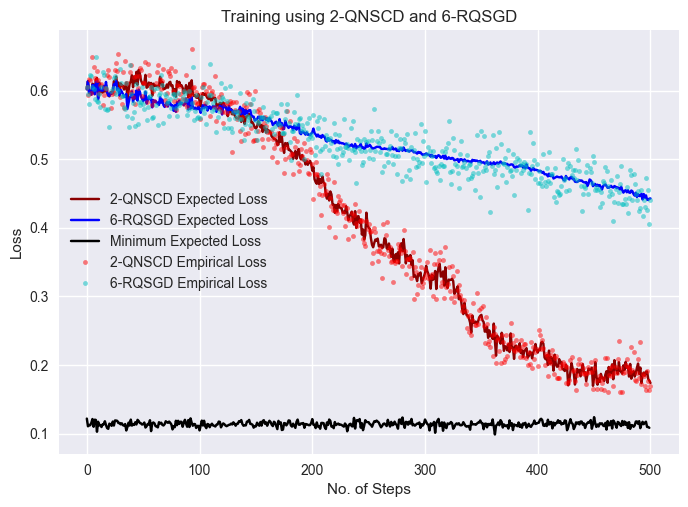

In [13]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6c_cost, "b", label="6-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6c_Ecost, "c.",alpha=0.5, label="6-RQSGD Empirical Loss")

plt.title("Training using 2-QNSCD and 6-RQSGD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.savefig("6-RQSGD.png")
plt.show()

## 2-RQSGD using 600 samples per step and 6 samples per itr

In [14]:
SGD6params = np.array(init_params)
SGD6_cost = []
SGD6_Ecost = []

SGD6_cost.append(temp_cost)
SGD6_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainSGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainSGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a 2 coordinates
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())
        
        grad = []
        
        ### Gradient estimation
        y_hat01,b01 = EstGrad(SGD6params,phiT[:,itr3+0],idx[0])
        b01 = (1-b01)/2
        y_hat02,b02 = EstGrad(SGD6params,phiT[:,itr3+1],idx[0])
        b02 = (1-b02)/2
        y_hat03,b03 = EstGrad(SGD6params,phiT[:,itr3+2],idx[0])
        b03 = (1-b03)/2
        
        temp0 = ((-1)**b01)*loss(y_hat01,labelT[itr3+0]) \
              + ((-1)**b02)*loss(y_hat02,labelT[itr3+1]) \
              + ((-1)**b03)*loss(y_hat03,labelT[itr3+2])

        grad.append((-1)*temp0/3)
        
        y_hat11,b11 = EstGrad(SGD6params,phiT[:,itr3+3],idx[1])
        b11 = (1-b11)/2
        y_hat12,b12 = EstGrad(SGD6params,phiT[:,itr3+4],idx[1])
        b12 = (1-b12)/2
        y_hat13,b13 = EstGrad(SGD6params,phiT[:,itr3+5],idx[1])
        b13 = (1-b13)/2
        
        temp1 = ((-1)**b11)*loss(y_hat11,labelT[itr3+3]) \
              + ((-1)**b12)*loss(y_hat12,labelT[itr3+4]) \
              + ((-1)**b13)*loss(y_hat13,labelT[itr3+5])

        grad.append((-1)*temp1/3)

        ### single-parameter update
        SGD6params[idx] = SGD6params[idx] - np.dot(step_size,grad)
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(SGD6params,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    SGD6_cost.append(energy)
    
    ### average empirical loss calculation
    SGD6count = 0   
    for itr in range(Bsize):
        if circuit_test(SGD6params,phiT[:,itr]) != labelT[itr]:
            SGD6count += 1
    SGD6_Ecost.append(SGD6count/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))


file_name1 = "6Q 2-RQSGD_6s Expected Loss"
file_name2 = "6Q 2-RQSGD_6s Empirical Loss"

np.save(file_name1,SGD6_cost)
np.save(file_name2,SGD6_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.61419
Batch count:  1, Avg. per-sample expected Loss: 0.59826
Batch count:  2, Avg. per-sample expected Loss: 0.60001
Batch count:  3, Avg. per-sample expected Loss: 0.59482
Batch count:  4, Avg. per-sample expected Loss: 0.60915
Batch count:  5, Avg. per-sample expected Loss: 0.60775
Batch count:  6, Avg. per-sample expected Loss: 0.59403
Batch count:  7, Avg. per-sample expected Loss: 0.61064
Batch count:  8, Avg. per-sample expected Loss: 0.61470
Batch count:  9, Avg. per-sample expected Loss: 0.58694
Batch count: 10, Avg. per-sample expected Loss: 0.61007
Batch count: 11, Avg. per-sample expected Loss: 0.59997
Batch count: 12, Avg. per-sample expected Loss: 0.60025
Batch count: 13, Avg. per-sample expected Loss: 0.59992
Batch count: 14, Avg. per-sample expected Loss: 0.60594
Batch count: 15, Avg. per-sample expected Loss: 0.59971
Batch count: 16, Avg. per-sample expected Loss: 0.61141
Batch count: 17, Avg. per-sample expected Loss: 

Batch count: 146, Avg. per-sample expected Loss: 0.58839
Batch count: 147, Avg. per-sample expected Loss: 0.59028
Batch count: 148, Avg. per-sample expected Loss: 0.58395
Batch count: 149, Avg. per-sample expected Loss: 0.58663
Batch count: 150, Avg. per-sample expected Loss: 0.58527
Batch count: 151, Avg. per-sample expected Loss: 0.59180
Batch count: 152, Avg. per-sample expected Loss: 0.59171
Batch count: 153, Avg. per-sample expected Loss: 0.58558
Batch count: 154, Avg. per-sample expected Loss: 0.59358
Batch count: 155, Avg. per-sample expected Loss: 0.58293
Batch count: 156, Avg. per-sample expected Loss: 0.59238
Batch count: 157, Avg. per-sample expected Loss: 0.59380
Batch count: 158, Avg. per-sample expected Loss: 0.58842
Batch count: 159, Avg. per-sample expected Loss: 0.59496
Batch count: 160, Avg. per-sample expected Loss: 0.59109
Batch count: 161, Avg. per-sample expected Loss: 0.59897
Batch count: 162, Avg. per-sample expected Loss: 0.59322
Batch count: 163, Avg. per-samp

Batch count: 290, Avg. per-sample expected Loss: 0.58003
Batch count: 291, Avg. per-sample expected Loss: 0.57554
Batch count: 292, Avg. per-sample expected Loss: 0.57531
Batch count: 293, Avg. per-sample expected Loss: 0.57834
Batch count: 294, Avg. per-sample expected Loss: 0.58359
Batch count: 295, Avg. per-sample expected Loss: 0.58408
Batch count: 296, Avg. per-sample expected Loss: 0.57328
Batch count: 297, Avg. per-sample expected Loss: 0.57404
Batch count: 298, Avg. per-sample expected Loss: 0.57394
Batch count: 299, Avg. per-sample expected Loss: 0.57554
Batch count: 300, Avg. per-sample expected Loss: 0.58401
Batch count: 301, Avg. per-sample expected Loss: 0.57684
Batch count: 302, Avg. per-sample expected Loss: 0.58101
Batch count: 303, Avg. per-sample expected Loss: 0.57444
Batch count: 304, Avg. per-sample expected Loss: 0.56947
Batch count: 305, Avg. per-sample expected Loss: 0.57810
Batch count: 306, Avg. per-sample expected Loss: 0.57536
Batch count: 307, Avg. per-samp

Batch count: 434, Avg. per-sample expected Loss: 0.56091
Batch count: 435, Avg. per-sample expected Loss: 0.56132
Batch count: 436, Avg. per-sample expected Loss: 0.56572
Batch count: 437, Avg. per-sample expected Loss: 0.55887
Batch count: 438, Avg. per-sample expected Loss: 0.56360
Batch count: 439, Avg. per-sample expected Loss: 0.56691
Batch count: 440, Avg. per-sample expected Loss: 0.56021
Batch count: 441, Avg. per-sample expected Loss: 0.56267
Batch count: 442, Avg. per-sample expected Loss: 0.55549
Batch count: 443, Avg. per-sample expected Loss: 0.55911
Batch count: 444, Avg. per-sample expected Loss: 0.56594
Batch count: 445, Avg. per-sample expected Loss: 0.56252
Batch count: 446, Avg. per-sample expected Loss: 0.56198
Batch count: 447, Avg. per-sample expected Loss: 0.56280
Batch count: 448, Avg. per-sample expected Loss: 0.54875
Batch count: 449, Avg. per-sample expected Loss: 0.56210
Batch count: 450, Avg. per-sample expected Loss: 0.57023
Batch count: 451, Avg. per-samp

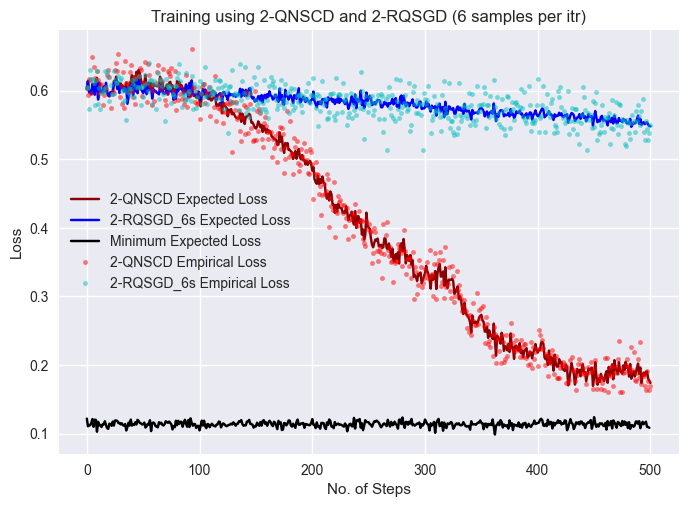

In [15]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="2-RQSGD_6s Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="2-RQSGD_6s Empirical Loss")

plt.title("Training using 2-QNSCD and 2-RQSGD (6 samples per itr)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.savefig("2RSGD_6s.png")
plt.show()

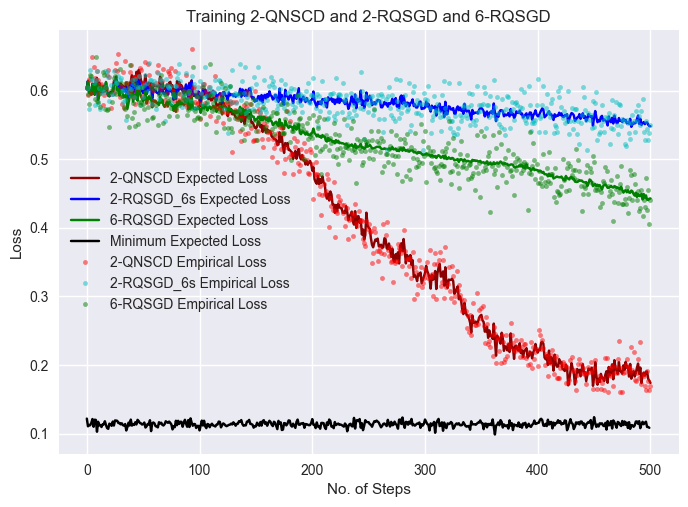

In [16]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="2-RQSGD_6s Expected Loss")
plt.plot(SGD6c_cost, "g", label="6-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="2-RQSGD_6s Empirical Loss")
plt.plot(SGD6c_Ecost, "g.",alpha=0.5, label="6-RQSGD Empirical Loss")

plt.title("Training 2-QNSCD and 2-RQSGD and 6-RQSGD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.savefig("RQSGD.png")
plt.show()

## Testing Phase

In [18]:
### Saving Final Parameters:
file_name1 = "6Q 2-QNSCD params"
file_name2 = "6Q 2-RQSGD_6s params"
file_name3 = "6Q 6-RQSGD params"

np.save(file_name1,NCGDparams)
np.save(file_name2,SGD6params)
np.save(file_name3,SGD6cparams)

In [19]:
phiTest = np.load('6-qubitsPhiTest_v1.npy')
labelTest = np.load('6-qubitsLabelTest_v1.npy')

phiTest.requires_grad = False
labelTest.requires_grad = False

In [20]:
nTest = 1000

NCGDparams_opt = NCGDparams 
SGD6params_opt = SGD6params
SGD6cparams_opt = SGD6cparams

In [21]:
### Optimal Expected Loss
expOperator = 0

for i in range(nTest):
    op = np.matmul(phiTest[:,i].reshape(dim,1),phiTest[:,i].reshape(1,dim))
    expOperator = expOperator + labelTest[i]*op
expOperator = expOperator/(nTest)
opt_value = 0.5*(1+sum(abs(np.linalg.svd(expOperator)[1])))

In [22]:
NCGD_rslt = []
SGD6_rslt = []
SGD6c_rslt = []

for i in range(int(1e1)):
    NCGDcount = 0
    SGD6count = 0
    SGD6ccount = 0

    for itr in range(nTest):
        if circuit_test(NCGDparams_opt,phiTest[:,itr]) == labelTest[itr]:
            NCGDcount += 1 
        if circuit_test(SGD6params_opt,phiTest[:,itr]) == labelTest[itr]:
            SGD6count += 1
        if circuit_test(SGD6cparams_opt,phiTest[:,itr]) == labelTest[itr]:
            SGD6ccount += 1
    
    NCGD_rslt.append(NCGDcount/nTest)
    SGD6_rslt.append(SGD6count/nTest)
    SGD6c_rslt.append(SGD6ccount/nTest)
#     print("itr = ",i)

In [23]:
print("Optimal: {:.3f} \nNCGD: {:.3f} / {:.3f} max: {:.3f} min: {:.3f} \n2-RQSGD_6s: {:.3f} / {:.3f} max: {:.3f} min: {:.3f} \n6-RQSGD: {:.3f} / {:.3f} max: {:.3f} min: {:.3f}"\
      .format(opt_value,np.average(NCGD_rslt),np.std(NCGD_rslt),max(NCGD_rslt),min(NCGD_rslt),\
              np.average(SGD6_rslt),np.std(SGD6_rslt),max(SGD6_rslt),min(SGD6_rslt), \
              np.average(SGD6c_rslt),np.std(SGD6c_rslt),max(SGD6c_rslt),min(SGD6c_rslt)))

Optimal: 0.880 
NCGD: 0.807 / 0.011 max: 0.823 min: 0.790 
2-RQSGD_6s: 0.447 / 0.018 max: 0.474 min: 0.411 
6-RQSGD: 0.561 / 0.014 max: 0.584 min: 0.534
